In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette()

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
SEED = 69

from utils import abcd
ABCD_PATH = '../../ABCD'

In [2]:
fcon, fc_extra = abcd.load_data(ABCD_PATH, 'fcon', include_rec=True, exclude_n=True)
scon, sc_extra = abcd.load_data(ABCD_PATH, 'scon', include_rec=True)

subs = fcon.index.intersection(scon.index).get_level_values(0).unique()
print(len(subs), 'subjects')

fcon = fcon.loc[subs]
scon = scon.loc[subs]

3936 subjects


In [3]:
covariates = abcd.load_covariates('output/abcd_covariates.csv', simple_race=True)

# Wendelken-FrontoparietalStructural-2017

In [4]:
# exclude subjects with any outliers (z > 3)
fcon_fo = fcon[abcd.FCON_TEMPLATE.format('fo', 'fo')]
scon_pslf = scon[[abcd.SCON_TEMPLATE.format('pslfrh'),
                  abcd.SCON_TEMPLATE.format('pslflh')]].mean(axis=1)

fcon_fo_outliers = fcon_fo.loc[np.abs(stats.zscore(fcon_fo)) > 3]
scon_pslf_outliers = scon_pslf.loc[np.abs(stats.zscore(scon_pslf)) > 3]
subs_noout = (subs.difference(fcon_fo_outliers.index.get_level_values(0))
              .difference(scon_pslf_outliers.index.get_level_values(0)))
print(len(subs_noout), 'subjects')

fcon_fo_noout = fcon_fo.loc[subs_noout]
scon_pslf_noout = scon_pslf.loc[subs_noout]

3823 subjects


## Demographics

### Age

In [5]:
age_month = covariates.loc[fcon_fo_noout.index, 'interview_age']
age_month_diff = age_month.groupby(level=0).diff().dropna().droplevel('eventname')

data_age = ((age_month / 12).reset_index('eventname')
            .rename(columns={'eventname':'Time Point'})
            .replace({abcd.EVENTS[0]:'baseline', abcd.EVENTS[1]:'year 2'}))

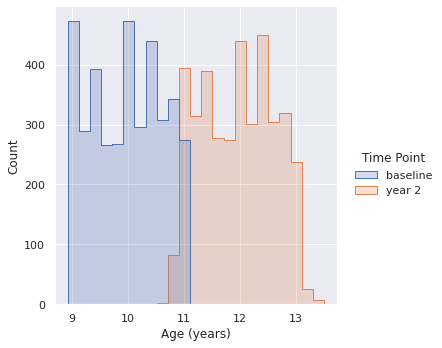

In [6]:
g = sns.displot(data_age, x='interview_age', hue='Time Point', element='step')
g.set_xlabels('Age (years)')

plt.show()

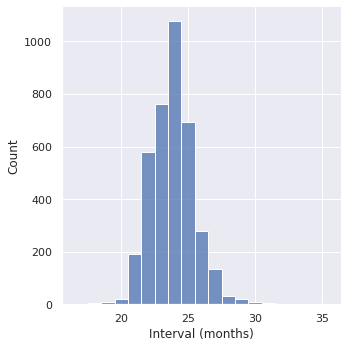

In [7]:
g = sns.displot(age_month_diff, discrete=True)
g.set_xlabels('Interval (months)')

plt.show()

### Sex

In [8]:
sex = covariates.loc[idx[subs_noout, abcd.EVENTS[1]], 'sex']

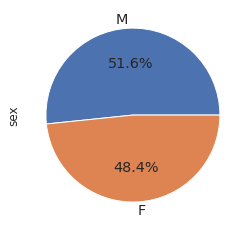

In [9]:
ax = sex.value_counts().plot.pie(autopct='%1.1f%%', textprops={'size':'large'})

plt.show()

### Race

In [10]:
race = covariates.loc[idx[subs_noout, abcd.EVENTS[1]], 'race']

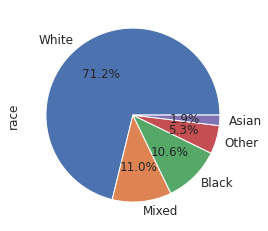

In [11]:
ax = race.value_counts().plot.pie(autopct='%1.1f%%', textprops={'size':'medium'})

plt.show()

## Connectivity

### Development

In [12]:
fcon_fo_age_linregress = stats.linregress(age_month / 12, fcon_fo_noout)
scon_pslf_age_linregress = stats.linregress(age_month / 12, scon_pslf_noout)

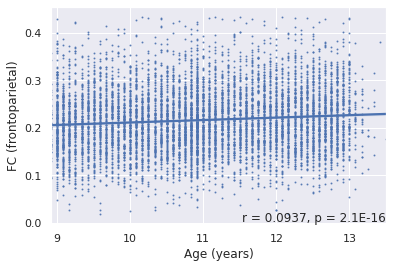

In [13]:
ax = sns.regplot(x=(age_month / 12), y=fcon_fo_noout, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('FC (frontoparietal)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=fcon_fo_age_linregress.rvalue,
                                              p=fcon_fo_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')

plt.show()

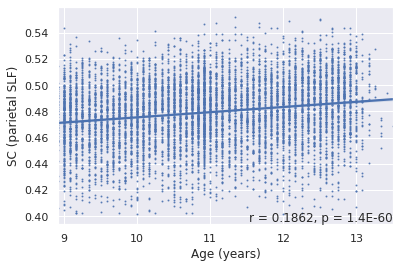

In [14]:
ax = sns.regplot(x=(age_month / 12), y=scon_pslf_noout, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('SC (parietal SLF)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=scon_pslf_age_linregress.rvalue,
                                              p=scon_pslf_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')

plt.show()

In [15]:
dFC_fo = (fcon_fo_noout.groupby(level=0)
          .diff().dropna().droplevel('eventname')
          .divide(age_month_diff / 12).dropna())
dSC_pslf = (scon_pslf_noout.groupby(level=0)
            .diff().dropna().droplevel('eventname')
            .divide(age_month_diff / 12).dropna())

In [16]:
dFC_fo_ttest = stats.ttest_1samp(dFC_fo, 0, alternative='greater')
dSC_pslf_ttest = stats.ttest_1samp(dSC_pslf, 0, alternative='greater')

In [17]:
print('frontoparietal FC change > 0, p = {p:.1E}'.format(p=dFC_fo_ttest[1]))
print('frontoparietal SC change > 0, p = {p:.1E}'.format(p=dSC_pslf_ttest[1]))

frontoparietal FC change > 0, p = 5.5E-22
frontoparietal SC change > 0, p = 1.1E-236


### SC-FC

#### Concurrent

In [18]:
data = (pd.DataFrame({'FC': fcon_fo_noout,
                      'SC': scon_pslf_noout})
        .join(age_month/12).join((age_month_diff/12).rename('age_diff'))
        .join(covariates['site_id']))

In [19]:
model = smf.mixedlm('FC ~ SC + interview_age', data, groups=data['site_id'])
results = model.fit()
results.summary()

/home/kimsin98/miniconda3/envs/neuro/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: FC        
No. Observations: 7646    Method:             REML      
No. Groups:       22      Scale:              0.0040    
Min. group size:  8       Log-Likelihood:     10218.7428
Max. group size:  905     Converged:          Yes       
Mean group size:  347.5                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.148    0.016 8.947 0.000  0.115  0.180
SC              0.032    0.034 0.946 0.344 -0.034  0.099
interview_age   0.005    0.001 7.770 0.000  0.004  0.006
Group Var       0.000    0.001                          
========================================================

"""

#### Longitudinal

In [20]:
data_long = (data.xs(abcd.EVENTS[0], level=1)
             .join(dFC_fo.rename('dFC'), how='right')
             .join(dSC_pslf.rename('dSC')))

In [21]:
def stepwise_selection(X, y, groups=None, p_enter=0.1, p_remove=0.3, verbose=True):
    """Forward-backward feature selection with OLS or MixedLM.
    yoinked from https://datascience.stackexchange.com/a/24447
    
    Parameters:
    - X: pandas.DataFrame with candidate features
    - y: list-like with the target
    - groups: columns of random intercepts (use MixedLM)
    - p_enter: include if p < p_enter
    - p_remove: exclude if p > p_remove
    - verbose: whether to print the sequence of inclusions and exclusions
    
    Returns:
    - results: final model results
    """
    if p_enter >= p_remove:
        raise ValueError('p_remove must be greater than p_enter to avoid infinite loop')
    
    if groups is not None:
        modelclass = sm.MixedLM
    else:
        modelclass = sm.OLS
    
    included = []
    changed = True
    while changed:
        changed = False
        
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = modelclass(y,
                               sm.add_constant(pd.DataFrame(X[included + [new_column]])),
                               groups=groups)
            new_pval[new_column] = model.fit().pvalues[new_column]
        
        best_pval = new_pval.min()
        if best_pval < p_enter:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:20} with p-value {:.4}'.format(best_feature, best_pval))
        
        # backward step
        model = modelclass(y,
                           sm.add_constant(pd.DataFrame(X[included])),
                           groups=groups)
        pvalues = model.fit().pvalues.iloc[1:] # all coeffs except intercept
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > p_remove:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:20} with p-value {:.4}'.format(worst_feature, worst_pval))
    
    model = modelclass(y,
                       sm.add_constant(pd.DataFrame(X[included])),
                       groups)
    return model.fit()

In [22]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter('ignore', ConvergenceWarning)
    results = stepwise_selection(data_long[['FC', 'SC', 'interview_age', 'age_diff', 'dSC']],
                                 data_long['dFC'],
                                 data_long['site_id'],
                                 p_enter=0.2, p_remove=0.4)

results.summary()

Add  FC                   with p-value 0.0
Add  SC                   with p-value 0.1935
Add  interview_age        with p-value 0.1702


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: dFC      
No. Observations:   3823    Method:             REML     
No. Groups:         22      Scale:              0.0009   
Min. group size:    8       Log-Likelihood:     7938.7776
Max. group size:    454     Converged:          Yes      
Mean group size:    173.8                                
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
const          0.081    0.013   6.331 0.000  0.056  0.107
FC            -0.338    0.008 -44.252 0.000 -0.353 -0.323
SC            -0.033    0.023  -1.445 0.148 -0.078  0.012
interview_age  0.001    0.001   1.371 0.170 -0.000  0.003
Group Var      0.000    0.001                            
=========================================================

"""

## More Confounds

In [23]:
fcon_fo_noout_confounds = (covariates.loc[fcon_fo_noout.index, ['sex', 'race', 'site_id']]
                           .join(fc_extra['rsfmri_c_ngd_meanmotion'].rename('meanmotion')))
scon_pslf_noout_confounds = (covariates.loc[scon_pslf_noout.index, ['sex', 'race', 'site_id']]
                             .join(sc_extra['dmri_dti_meanmotion'].rename('meanmotion')))

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', ConvergenceWarning)
    fcon_fo_noout_control = abcd.confound_residuals(
        fcon_fo_noout, model=sm.MixedLM,
        regressors=fcon_fo_noout_confounds[['sex', 'race', 'meanmotion']],
        groups=fcon_fo_noout_confounds['site_id']
    )
    scon_pslf_noout_control = abcd.confound_residuals(
        scon_pslf_noout, model=sm.MixedLM,
        regressors=scon_pslf_noout_confounds[['sex', 'race', 'meanmotion']],
        groups=scon_pslf_noout_confounds['site_id']
    )

### Development

In [25]:
fcon_fo_control_age_linregress = stats.linregress(age_month / 12, fcon_fo_noout_control)
scon_pslf_control_age_linregress = stats.linregress(age_month / 12, scon_pslf_noout_control)

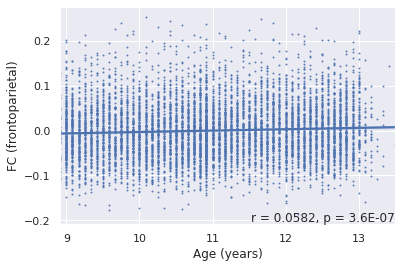

In [26]:
ax = sns.regplot(x=(age_month / 12), y=fcon_fo_noout_control, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('FC (frontoparietal)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=fcon_fo_control_age_linregress.rvalue,
                                              p=fcon_fo_control_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')

plt.show()

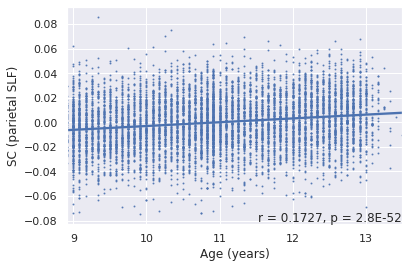

In [27]:
ax = sns.regplot(x=(age_month / 12), y=scon_pslf_noout_control, scatter_kws={'s': 1})
ax.set_xlabel('Age (years)')
ax.set_ylabel('SC (parietal SLF)')
ax.annotate('r = {r:.4f}, p = {p:.1E}'.format(r=scon_pslf_control_age_linregress.rvalue,
                                              p=scon_pslf_control_age_linregress.pvalue),
            xy=(1, 0), xycoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom')

plt.show()

In [28]:
dFC_fo_control = (fcon_fo_noout_control.groupby(level=0)
                  .diff().dropna().droplevel('eventname')
                  .divide(age_month_diff / 12).dropna())
dSC_pslf_control = (scon_pslf_noout_control.groupby(level=0)
                    .diff().dropna().droplevel('eventname')
                    .divide(age_month_diff / 12).dropna())

In [29]:
dFC_fo_control_ttest = stats.ttest_1samp(dFC_fo_control, 0, alternative='greater')
dSC_pslf_control_ttest = stats.ttest_1samp(dSC_pslf_control, 0, alternative='greater')

In [30]:
print('frontoparietal FC change > 0, p = {p:.1E}'.format(p=dFC_fo_control_ttest[1]))
print('frontoparietal SC change > 0, p = {p:.1E}'.format(p=dSC_pslf_control_ttest[1]))

frontoparietal FC change > 0, p = 4.7E-10
frontoparietal SC change > 0, p = 8.4E-154


### SC-FC

#### Concurrent

In [31]:
data = (pd.DataFrame({'FC': fcon_fo_noout_control,
                      'SC': scon_pslf_noout_control})
        .join(age_month/12).join((age_month_diff/12).rename('age_diff')))

In [32]:
model = smf.ols('FC ~ SC + interview_age', data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     FC   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     12.98
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           2.36e-06
Time:                        18:37:55   Log-Likelihood:                 10416.
No. Observations:                7646   AIC:                        -2.083e+04
Df Residuals:                    7643   BIC:                        -2.081e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0337      0.007     -5.000      0.000      -0.047      -0.020
SC               -0.0019      0.034     -0.056      0.955      -0.069       0.065
interview_age     0.0031      0.001      5.028      0.000       0.002       0.004
==============================================================================
Omnibus:                      346.728   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              407.978
Skew:                           0.509   Prob(JB):                     2.56e-89
Kurtosis:                       3.494   Cond. No.                         534.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Longitudinal

In [33]:
data_long = (data.xs(abcd.EVENTS[0], level='eventname')
             .join(dFC_fo_control.rename('dFC'), how='right')
             .join(dSC_pslf_control.rename('dSC')))

In [34]:
results = stepwise_selection(data_long[['FC', 'SC', 'interview_age', 'age_diff', 'dSC']],
                             data_long['dFC'],
                             p_enter=0.2, p_remove=0.4)

results.summary()

Add  FC                   with p-value 0.0
Add  SC                   with p-value 0.1027
Add  interview_age        with p-value 0.1553


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    dFC   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     701.6
Date:                Thu, 22 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:37:55   Log-Likelihood:                 8034.0
No. Observations:                3823   AIC:                        -1.606e+04
Df Residuals:                    3819   BIC:                        -1.603e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0087      0.008     -1.124      0.261      -0.024       0.006
FC               -0.3501      0.008    -45.816      0.000      -0.365      -0.335
SC               -0.0408      0.023     -1.769      0.077      -0.086       0.004
interview_age     0.0011      0.001      1.421      0.155      -0.000       0.003
==============================================================================
Omnibus:                      159.152   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.662
Skew:                           0.431   Prob(JB):                     8.07e-46
Kurtosis:                       3.748   Cond. No.                         484.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVR with whole SC

* target: Δ frontoparietal connectivity
* features: t0 frontoparietal connectivity, t0 structural connectome, age, sex, race, SC/FC mean motion

In [35]:
fcon_fo = fcon[abcd.FCON_TEMPLATE.format('fo', 'fo')]

age = covariates.loc[fcon_fo.index, 'interview_age'] / 12
age_diff = (age.groupby(level=0)
            .diff().dropna().droplevel('eventname'))

y = (fcon_fo.groupby(level=0)
     .diff().dropna().droplevel('eventname')
     .divide(age_diff).dropna())

In [36]:
X = (pd.DataFrame(fcon_fo).loc[idx[:, abcd.EVENTS[0]], :]
     .join(scon)
     .join(age)
     .join(covariates['sex'].astype('category'))
     .join(covariates['race'].astype('category').fillna('Other'))
     .join(fc_extra['rsfmri_c_ngd_meanmotion'].rename('fc_meanmotion'))
     .join(sc_extra['dmri_dti_meanmotion'].rename('sc_meanmotion'))
     .droplevel('eventname'))

In [37]:
family = covariates.loc[idx[X.index, abcd.EVENTS[0]], 'rel_family_id'].droplevel('eventname')

## Preprocess

In [38]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=SEED)
train, test = next(gss.split(X, y, family))

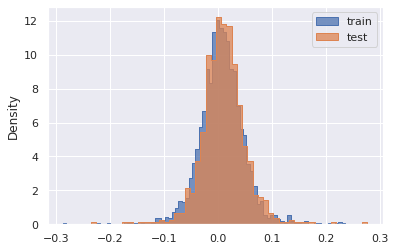

In [39]:
sns.histplot(y.iloc[train], label='train', stat='density', element='step', color=colors[0])
sns.histplot(y.iloc[test], label='test', stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

In [40]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

preprocess = make_column_transformer(
    (StandardScaler(), X.columns.difference(['sex', 'race'])),
    (OneHotEncoder(), ['sex', 'race']),
    n_jobs=4)

In [41]:
X_train = preprocess.fit_transform(X.iloc[train])
y_train = y.iloc[train].to_numpy()

## Model

In [42]:
from sklearn.svm import LinearSVR

l_svr = LinearSVR(loss='epsilon_insensitive', tol=1e-3, max_iter=1e5, random_state=SEED)

In [43]:
from sklearn.model_selection import cross_validate, GroupKFold

cv_l_svr = cross_validate(l_svr, X_train, y_train, scoring=['explained_variance', 'neg_mean_absolute_error'],
                          cv=GroupKFold(), groups=family.iloc[train],
                          n_jobs=4)

In [44]:
for i, (ev, negmae) in enumerate(zip(cv_l_svr['test_explained_variance'],
                                     cv_l_svr['test_neg_mean_absolute_error'])):
    print('Fold {} -- EV = {:.4f}, MAE = {:.4f}'.format(i+1, ev, -negmae))

Fold 1 -- EV = 0.3454, MAE = 0.0248
Fold 2 -- EV = 0.3463, MAE = 0.0261
Fold 3 -- EV = 0.3778, MAE = 0.0245
Fold 4 -- EV = 0.3268, MAE = 0.0266
Fold 5 -- EV = 0.3054, MAE = 0.0243


In [45]:
X_test = preprocess.transform(X.iloc[test])
y_test = y.iloc[test].to_numpy()

l_svr.fit(X_train, y_train)
y_pred = l_svr.predict(X_test)

EV:  0.30059973454276867
MAE:  0.025628335087927265


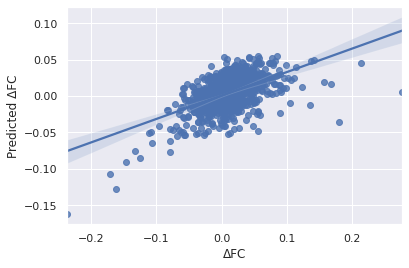

In [46]:
from sklearn.metrics import explained_variance_score, mean_absolute_error

print('EV: ', explained_variance_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))

ax = sns.regplot(x=y_test, y=y_pred)
ax.set_xlabel('ΔFC')
ax.set_ylabel('Predicted ΔFC')

plt.show()

## Interpret

In [47]:
features = (list(X.columns[:X.columns.get_loc('sex')])
            + list(preprocess.named_transformers_['onehotencoder'].get_feature_names())
            + list(X.columns[X.columns.get_loc('race') + 1:]))

In [48]:
coeffs = pd.Series(l_svr.coef_, index=features)

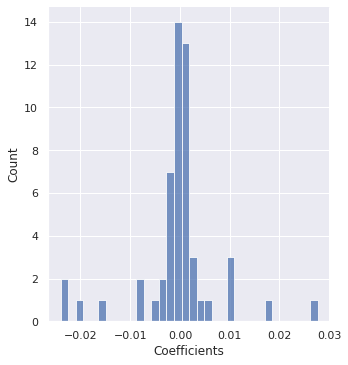

In [49]:
g = sns.displot(coeffs)
g.set_xlabels('Coefficients')

plt.show()

In [50]:
top_coeffs = coeffs.sort_values(ascending=False, key=abs).iloc[:6]
display(top_coeffs)

dmri_dtifa_fiberat_fxcutlh    0.027669
x0_F                         -0.024006
dmri_dtifa_fiberat_sifclh    -0.022765
dmri_dtifa_fiberat_pscslh    -0.020081
dmri_dtifa_fiberat_fscslh     0.017857
dmri_dtifa_fiberat_cgcrh     -0.016299
dtype: float64

In [51]:
scon_labels = pd.Series(abcd.get_scon_dict(ABCD_PATH))

scon_labels.loc[top_coeffs.index[top_coeffs.index != 'x0_F']
                .str.replace(abcd.SCON_TEMPLATE.format(''), '')]

fxcutlh                       left fornix, excluding fimbria
sifclh                 left striatal inferior frontal cortex
pscslh     left superior corticostriate-parietal cortex only
fscslh      left superior corticostriate-frontal cortex only
cgcrh                               right cingulate cingulum
dtype: object

In [52]:
coeffs.abs().rank(ascending=False).loc[[
    abcd.FCON_TEMPLATE.format('fo', 'fo'),
    abcd.SCON_TEMPLATE.format('pslfrh'),
    abcd.SCON_TEMPLATE.format('pslflh')
]]

rsfmri_c_ngd_fo_ngd_fo        9.0
dmri_dtifa_fiberat_pslfrh    27.0
dmri_dtifa_fiberat_pslflh    35.0
dtype: float64